In [1]:
import os
import pickle
import logging

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import arviz as az
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep_paper.utils import setup_logging
from models import (
    RectifiedLogistic,
    Logistic5,
    Logistic4,
    RectifiedLinear
)
from constants import DATA_PATH, NETCODE_FILE, INFERENCE_FILE

plt.rcParams["svg.fonttype"] = "none"
logger = logging.getLogger(__name__)

BUILD_DIR = "/home/vishu/repos/hbmep-paper/reports/cross-validation/rats/"
os.makedirs(BUILD_DIR, exist_ok=True)
setup_logging(
    dir=BUILD_DIR,
    fname="figure__cross-validation"
)


: 

In [53]:
posterior_dirs = [
    ("rats", "/home/vishu/repos/hbmep-paper/reports/cross-validation/rats"),
    ("tms", "/home/vishu/repos/hbmep-paper/reports/cross-validation/tms"),
    ("intraoperative", "/home/vishu/repos/hbmep-paper/reports/cross-validation/intraoperative"),
]

models = [
    ("rectified_logistic", "Rectified-logistic", F.rectified_logistic, [site.a, site.b, site.L, site.ell, site.H]),
    ("logistic5", "Logistic-5", F.logistic5, [site.a, site.b, site.v, site.L, site.H]),
    ("logistic4", "Logisitc-4", F.logistic4, [site.a, site.b, site.L, site.H]),
    ("rectified_linear", "Rectified-linear", F.rectified_linear, [site.a, site.b, site.L])
]


In [6]:
model_dict = {}

for dataset, posterior_dir in posterior_dirs:
    model_dict[dataset] = {}

    for model_dir, model_name, _, _ in models:
        src = os.path.join(posterior_dir, model_dir, NETCODE_FILE)
        model_dict[dataset][model_name] = az.from_netcdf(src)


In [7]:
compare_dfs = {}
for dataset, _ in posterior_dirs:
    compare_dfs[dataset] = az.compare(model_dict[dataset]);


/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/li

In [10]:
rats_models = [RectifiedLogistic, Logistic5, Logistic4, RectifiedLinear]

for i, Model in enumerate(rats_models):
    src = os.path.join(posterior_dirs[0][1], Model.NAME, INFERENCE_FILE)
    with open(src, "rb") as g:
        rats_models[i] = pickle.load(g)     # model, mcmc, posterior_samples

base_model = rats_models[0][0]


2024-03-06 16:42:14,585 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': 
2024-03-06 16:42:14,594 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-03-06 16:42:14,597 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [14]:
df = pd.read_csv(DATA_PATH)
df, encoder_dict = base_model.load(df=df)

c = (encoder_dict[base_model.features[0]].transform(["amap05___C5M-C6L"])[0],)
ind = df[base_model.features].apply(tuple, axis=1).isin([c])
df = df[ind].reset_index(drop=True).copy()

n_pulses = 5000
prediction_df = base_model.make_prediction_dataset(df=df, num_points=n_pulses, min_intensity=0.0, max_intensity=205)


2024-03-06 16:44:53,617 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/cross-validation/rats/rectified_logistic
2024-03-06 16:44:53,654 - hbmep.dataset.core - INFO - Processing data ...
2024-03-06 16:44:53,658 - hbmep.utils.utils - INFO - func:load took: 0.04 sec


2024-03-06 16:44:53,720 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


In [15]:
rats_ppd = []

for model, _, posterior_samples in rats_models:
    rats_ppd.append(model.predict(df=prediction_df, posterior_samples=posterior_samples))


2024-03-06 16:46:54,350 - hbmep.utils.utils - INFO - func:predict took: 1 min and 43.91 sec
2024-03-06 16:48:29,139 - hbmep.utils.utils - INFO - func:predict took: 1 min and 34.79 sec
2024-03-06 16:49:55,952 - hbmep.utils.utils - INFO - func:predict took: 1 min and 26.80 sec
2024-03-06 16:51:26,291 - hbmep.utils.utils - INFO - func:predict took: 1 min and 30.34 sec


In [16]:
rats_obs_hpdi= [hpdi(ppd[site.obs], prob=.95) for ppd in rats_ppd]


In [17]:
pulses = prediction_df[base_model.intensity].unique()

out = [
    [
        fn,
        [rats_models[i][-1][param].mean(axis=0)[c[0], 0] for param in params]
    ]
    for i, (_, _, fn, params) in enumerate(models)
]

out = [
    [
        fn,
        [np.array([param] * n_pulses) for param in params]
    ]
    for fn, params in out
]

out = [fn(pulses, *params) for fn, params in out]


2024-03-06 17:17:56,338 - __main__ - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/cross-validation/rats/function_comparison.png


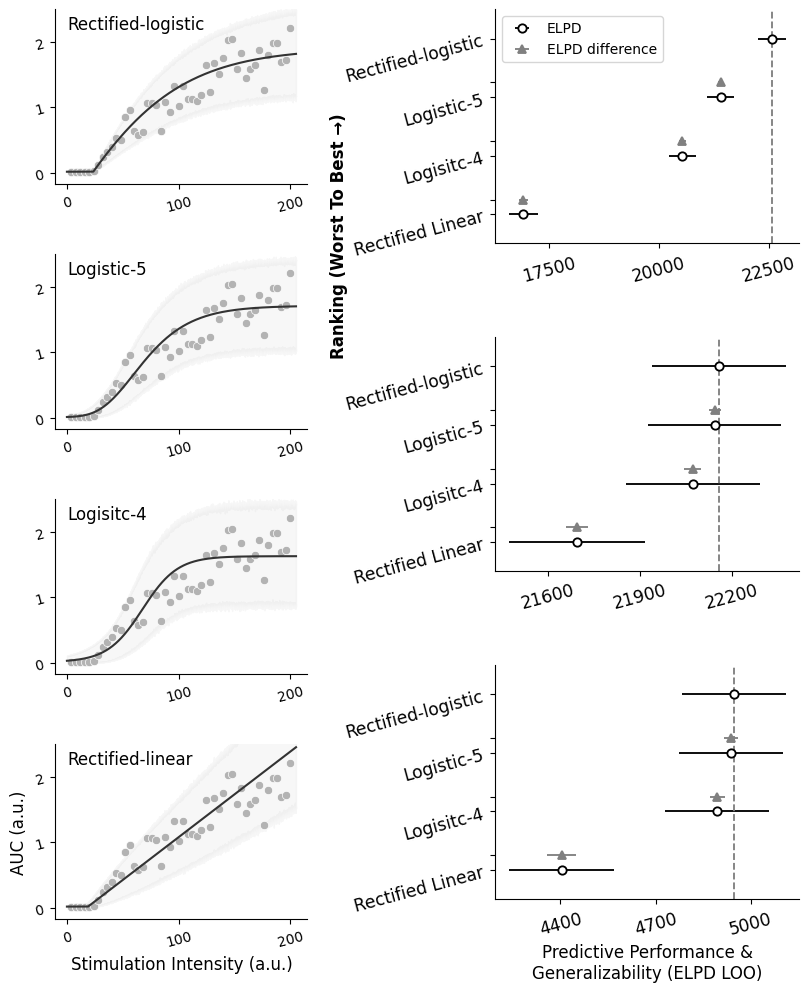

In [62]:
max_color, max_alpha = 255, 100
posterior_color = (204 / max_color, 204 / max_color, 204 / max_color, 15 / max_alpha)
curve_color = (51 / max_color, 51 / max_color, 51 / max_color, 100 / max_alpha)
scatter_color = (179 / max_color, 179 / max_color, 179 / max_color, 100 / max_alpha)
scatter_edgecolor = (255 / max_color, 255 / max_color, 255 / max_color, 100 / max_alpha)


def plot_ppd(ax, i):
    model_name = models[i][1]
    ax.fill_between(
        prediction_df[base_model.intensity],
        rats_obs_hpdi[i][0, :, 0],
        rats_obs_hpdi[i][1, :, 0],
        color=posterior_color
    )
    sns.scatterplot(x=df[base_model.intensity], y=df[base_model.response[0]], color=scatter_color, edgecolor=scatter_edgecolor, ax=ax)
    sns.lineplot(x=prediction_df[base_model.intensity], y=out[i], color=curve_color, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    ax.text(0, 2.2, model_name, fontsize=12)
    return


def plot_compare_df(ax, compare_df):
    az.plot_compare(comp_df=compare_df, ax=ax)
    ax.legend(loc="upper left")
    ax.get_legend().remove()
    ax.set_xlabel("Expected Log-Predictive Density (ELPD)")
    ax.set_ylabel("Ranking (Worst To Best →)")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    return

fig = plt.figure(figsize=(8, 10))
subfigs = fig.subfigures(1, 2)

subfig = subfigs.flat[0]
axes = subfig.subplots(4, 1, sharex=True, sharey=True, squeeze=False)

for i, ax in enumerate(axes.flat):
    plot_ppd(ax, i)
    sides = ["top", "right"]
    for side in sides:
        ax.spines[side].set_visible(False)
    ax.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=True,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15
    )

ax = axes[0, 0]
ax.set_xticks([0., 100., 200.])
ax.set_yticks([0., 1., 2.])
ax.set_ylim(top=2.5)

ax = axes[-1, 0]
ax.set_ylabel("AUC (a.u.)", fontsize=12)
ax.set_xlabel("Stimulation Intensity (a.u.)", fontsize=12)

subfig.subplots_adjust(left=.12, right=.75, bottom=.07, top=.98, hspace=.4)

subfig = subfigs.flat[1]
axes = subfig.subplots(3, 1, squeeze=False)

for i, ax in enumerate(axes.flat):
    sides = ["top", "right"]
    for side in sides:
        ax.spines[side].set_visible(False)
    ax.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=True,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15
    )
    compare_df = compare_dfs[posterior_dirs[i][0]]
    plot_compare_df(ax, compare_df)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    if i == 0: ax.set_xticks([17500, 20000, 22500])
    if i == 1: ax.set_xticks([21600, 21900, 22200])
    if i == 2: ax.set_xticks([4400, 4700, 5000])
    if not i: ax.legend(loc="upper left")

ax = axes[0, 0]
ax.text(12500, -1.8, "Ranking (Worst To Best →)", fontsize=12, fontweight="bold", rotation=90)

ax = axes[-1, 0]
ax.set_xlabel("Predictive Performance &\nGeneralizability (ELPD LOO)", fontsize=12)

subfig.subplots_adjust(left=.22, right=.98, bottom=.09, top=.98, hspace=.4)

fig.align_xlabels()
fig.align_ylabels()
fig.align_labels()

dest = os.path.join(BUILD_DIR, "function_comparison.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(BUILD_DIR, "function_comparison.png")
fig.savefig(dest, dpi=600)
logger.info(f"Saved to {dest}")

